 # Regression with PyTorch
 This notebook will show you how to do a simple regression with PyTorch. We will use
 the  [California housing
 dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)
 to estimate the median house value in a given block based on a number of household
 features.
 > Note: Example pulled from [here](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/)

 ##Handle our imports in one block for reproduciability.

In [1]:
%matplotlib inline

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm.auto
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


 ## Load our data
 Most machine learning frameworks include (cleaned) toy datasets for learning concepts and
 benchmarking. Here's how we can load the California housing dataset from scikit-learn.
 It can be used like a dictionary, but with dot-indexing as well.

In [2]:
data = fetch_california_housing()
_ = [print(f"{k}") for k in data.keys()]


data
target
frame
target_names
feature_names
DESCR


 We're interested in the data and target values. The data is a 2D array of features,
 and the target is a 1D array of the median house value in a given block. Let's check
 their names

In [3]:
print(f"Target: {data.target_names}")
print(f"Features: {data.feature_names}")



Target: ['MedHouseVal']
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


 Let's get those into a pandas dataframe for easier inspection.
 > Note: the median house value is in units of 100,000 USD

In [4]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df[data.target_names[0]] = data.target
df.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


 ## Data Preparation
 We need to split our data into training and validation sets. We'll use 70% of the data
 for training and 30% for validation. We'll also standardize the data to have a mean of 0
 and a standard deviation of 1. This is a common preprocessing step for neural
 networks.
 Note: Scikit sticks to numpy arrays, with generic names, so we'll use those. You
 should also split your data into training, validation, and _test_ sets for real
 research. When you're tuning your hyperparameters, you're likely to overfit to your
 validation data, so you need to keep a separate test set to evaluate your model on
 after you've finished tuning.

 Train-validate split for model evaluation.

In [5]:
X, y = data.data, data.target
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

print(f"Training data shape: {X_train_raw.shape}")
print(f"Validation data shape: {X_valid_raw.shape}")


Training data shape: (14447, 8)
Validation data shape: (6193, 8)


 Standardizing data using scikit-learn's `StandardScaler`. Scaling will improve the
 model accuracy, but I found it increased the runtime a bit.

In [6]:
use_scaling = True
if use_scaling:
    scaler = StandardScaler()  # There's more options than this one
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_valid = scaler.transform(X_valid_raw)
else:
    X_train = X_train_raw
    X_valid = X_valid_raw

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32).reshape(-1, 1)


 ## Defining our network
 Remember that we need the following items to train a neural network:
 - Data
 - A model
 - A loss function
 - An optimizer

 ### Defining the model
 We'll use a simple feed-forward neural network with 4 layers. I'm leaving these
 hardcoded, but notice that the input and output sizes are determined by the number of
 features (columns) in our X data and the number of feautures (columns) in our y data.

 The linear layers are the same matrix multiplication we saw in the slides. The ReLU is
 a commonly used activation function that keeps only positive values and introduces
 nonlinearity.  Since successive linear matrix multiplications can be represented with
 a single matrix, every intermediate (hidden) layer needs a nonlinear activation
 function.
 This network is using a structure where we decrease the number of "neurons" (weights)
 in each layer. This one is using a halving scheme, but you can try others. If we made
 this into a function, we could say how many layers we want, and how many neurons in
 the first layer, and try more options.

In [7]:
model = nn.Sequential(
    nn.Linear(in_features=8, out_features=24),  # Z_i = W_ij * x_j + b_i
    nn.ReLU(),  # keep only positive values, introduce nonlinearity
    nn.Linear(in_features=24, out_features=12),
    nn.ReLU(),
    nn.Linear(in_features=12, out_features=6),
    nn.ReLU(),
    nn.Linear(in_features=6, out_features=1),
)


 ### Loss function and optimizer
 We'll use mean squared error (MSE) as our loss function. This is a common loss
 function for regression tasks. We'll use the Adam optimizer which stands for Adaptive
 Moment Estimation. It's a common optimizer that uses adaptive learning rates and
 momentum (equation term for getting out of local minima) to speed up convergence.

In [8]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


 ## Training
 We'll train for 4 epochs (passes through the data) with a batch size of 10. Training
 takes a while, so we'll use the `tqdm` library to show progress bars. We'll also keep
 track of the best model weights and return those at the end. We'll need two loops, one
 for each epoch and one for each batch.
 Reminder of what a training loop looks like:

 ![network-structure](../attachments/01-kg-regression/network-structure.png)
 
 Our model will already have the initial weights, so we don't need to initialize them
 manually.

In [9]:
n_epochs = 100  # number of epochs to train for
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)  # start index of each batch

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
train_history = []
valid_history = []

with tqdm.notebook.trange(n_epochs, unit="epoch") as bar:
    bar.set_description("Epoch Progress")
    for epoch in bar:
        model.train()
        for start in batch_start:
            # take a batch
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass (calculating our model predictions)
            y_valid_pred = model(X_batch)
            loss = loss_fn(y_valid_pred, y_batch)
            # backward pass (calculate gradients)
            optimizer.zero_grad()
            loss.backward()  # backward propagation
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))

        # evaluate our chosen loss metric at end of each epoch
        model.eval()

        # Evaluate the model on the training and validation data
        y_train_pred = model(X_train)
        train_mse = loss_fn(y_train_pred, y_train)
        train_mse = float(train_mse)
        train_history.append(train_mse)

        y_valid_pred = model(X_valid)
        valid_mse = loss_fn(y_valid_pred, y_valid)
        valid_mse = float(valid_mse)
        valid_history.append(valid_mse)

        # Update the best weights
        if valid_mse < best_mse:
            best_mse = valid_mse
            best_weights = copy.deepcopy(model.state_dict())


  0%|          | 0/100 [00:00<?, ?epoch/s]

 ## Evaluation
 Let's plot our training history to see how our model did.

MSE: 0.30
RMSE: 0.55


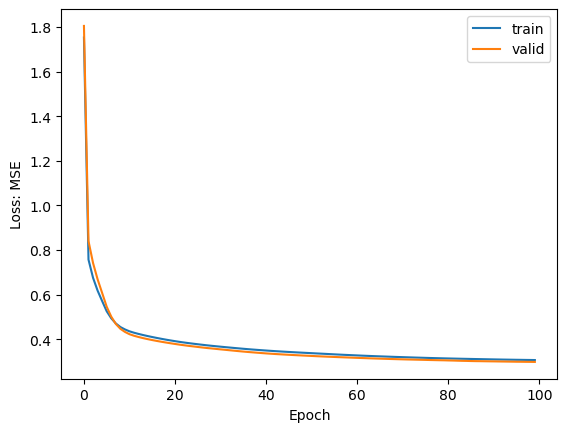

In [10]:
# restore model and return best version with the lowest validation loss
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
# Overlay the training and validation loss history in a plot
plt.plot(train_history, label="train")
plt.plot(valid_history, label="valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss: MSE")
plt.show()


In [11]:
model.eval()
with torch.no_grad():  # Reduce memory usage during inference
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_valid_raw[i : i + 1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_valid_pred = model(X_sample)
        print(
            f"{X_valid_raw[i]} -> {y_valid_pred[0].numpy()} (expected {y_valid[i].numpy()})"
        )


[   7.5197   42.        4.24      0.72     40.        1.6      38.22
 -122.28  ] -> [3.8984962] (expected [2.75])
[   4.95         36.            5.73850575    1.02298851  772.
    2.2183908    37.75       -122.45      ] -> [3.225952] (expected [3.226])
[   4.9464       14.            5.09716599    0.96356275  889.
    3.59919028   32.91       -117.15      ] -> [1.748053] (expected [1.748])
[ 4.75690000e+00  1.90000000e+01  5.70181219e+00  1.04448105e+00
  2.79000000e+03  4.59637562e+00  3.69600000e+01 -1.21750000e+02] -> [2.0102959] (expected [1.908])
[   4.0238       15.            3.8490566     1.02725367  942.
    1.97484277   33.72       -118.04      ] -> [2.3648708] (expected [1.825])
